In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
power = pd.read_csv("C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/power_data.txt",names=["power_demand"])


In [3]:
sub_power = pd.Series(power[490:51*84*8+490].reset_index(drop=True)["power_demand"])
sub_power = sub_power[::8].reset_index(drop=True)
sub_power = sub_power.reshape(-1, 1)
scaler = MinMaxScaler()
scaler.fit(sub_power)
sub_power = scaler.transform(sub_power) 

sub_power_ = np.array([sub_power[t][0] for t in range(sub_power.shape[0])])
sub_power_list = [sub_power_[t*84:(t+1)*84] for t in range(51)]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [4]:
anomalous_indices = [11,12,16,17,19,38,50]
normal_indices = list(set(range(51))-set(anomalous_indices))
dataset_normal = [sub_power_list[i] for i in normal_indices]
dataset_anomalous = [sub_power_list[j] for j in anomalous_indices]

In [5]:
label = np.array(['anomaly' for _ in range(51)])
label[normal_indices] = 'normal'
label = [[x]*84 for x in label]
label = np.array(label).ravel()

In [6]:
sub_power.shape

(4284, 1)

In [7]:
data = pd.concat((pd.DataFrame(sub_power),pd.Series(label)),axis=1)

In [8]:
#data.to_csv("C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/power_data_labeled_unscaled.csv",header=None,index=None)

In [9]:
test_set = data[1008:]


# Autoencoder anomaly detection

In [10]:

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time

## Reload power_demand autoencoder from disk

In [11]:
#modelpath_root ="C:/Users/Bin/Desktop/Thesis/tmp/EncDecADModel_online_init/power_demand/Try1_2_40_84/"
modelpath_root ="C:/Users/Bin/Desktop/Thesis/tmp/EncDecADModel_online_init/power_demand/Try6_1_40_84/"
modelmeta_p = modelpath_root + "LSTMAutoencoder_power_1_40_84_para.ckpt.meta"
step_num = 84
hidden_num = 40
batch_num = 1
elem_num = 1

In [12]:
#test_set_list = [test_set.iloc[:3192,0].as_matrix().reshape(19,2,84,1)[a] for a in range(19)]
test_set_list = [test_set.iloc[:,0].as_matrix().reshape(39,1,84,1)[a] for a in range(39)]

In [13]:
sess = tf.Session()
saver = tf.train.import_meta_graph(modelmeta_p) # load trained gragh, but without the trained parameters
saver.restore(sess,tf.train.latest_checkpoint(modelpath_root))
graph = tf.get_default_graph()

p_input = graph.get_tensor_by_name("p_input:0")
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)] 
#        p_is_training = tf.placeholder(tf.bool)
p_is_training = graph.get_tensor_by_name("is_training_:0")

input_= tf.transpose(tf.stack(p_inputs), [1, 0, 2])    
output_ = graph.get_tensor_by_name("decoder/output_:0")

tensor_mu = graph.get_tensor_by_name("mu:0")
tensor_sigma = graph.get_tensor_by_name("sigma:0")
tensor_threshold = graph.get_tensor_by_name("threshold:0")

loss_ = graph.get_tensor_by_name("decoder/loss:0")
train_ = graph.get_operation_by_name("cond/train_")

mu = sess.run(tensor_mu)
sigma = sess.run(tensor_sigma)
threshold = sess.run(tensor_threshold)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/EncDecADModel_online_init/power_demand/Try6_1_40_84/LSTMAutoencoder_power_1_40_84_para.ckpt


# Retrain according to performance

## 1. retrain when error.max >= err.max[0]

Retrain at batch number 0

Retrain-iter 1: 0.0376681
Retrain-iter 2: 0.0357718
Retrain-iter 3: 0.0315341
Retrain-iter 4: 0.0272996
Retrain-iter 5: 0.0246065
Retrain-iter 6: 0.0237392
Retrain-iter 7: 0.0241727
Retrain-iter 8: 0.0251126
Retrain-iter 9: 0.025795
Retrain-iter 10: 0.0256815
Retrain-iter 11: 0.0246523
Retrain-iter 12: 0.0230376
Retrain-iter 13: 0.0213749
Retrain-iter 14: 0.0200786
Retrain-iter 15: 0.0192919
Retrain-iter 16: 0.018955
Retrain-iter 17: 0.0189215
Retrain-iter 18: 0.0190072
Retrain-iter 19: 0.0190156
Retrain-iter 20: 0.018804
Retrain-iter 21: 0.0183534
Retrain-iter 22: 0.0177626
Retrain-iter 23: 0.0171664
Retrain-iter 24: 0.0166581
Retrain-iter 25: 0.0162739
Retrain-iter 26: 0.0160176
Retrain-iter 27: 0.0158724
Retrain-iter 28: 0.0157958
Retrain-iter 29: 0.0157269
Retrain-iter 30: 0.0156139
Retrain-iter 31: 0.0154374
Retrain-iter 32: 0.0152109
Retrain-iter 33: 0.0149619
Retrain-iter 34: 0.0147156
Retrain-iter 35: 0.0144903
Retrain-iter 36: 0.0142994
Retrain-iter 

Retrain-iter 293: 0.00472265
Retrain-iter 294: 0.00470385
Retrain-iter 295: 0.00468491
Retrain-iter 296: 0.00466582
Retrain-iter 297: 0.00464659
Retrain-iter 298: 0.00462721
Retrain-iter 299: 0.00460768
Retrain-iter 300: 0.00458799
Retrain-iter 301: 0.00456815
Retrain-iter 302: 0.00454816
Retrain-iter 303: 0.00452801
Retrain-iter 304: 0.00450771
Retrain-iter 305: 0.00448725
Retrain-iter 306: 0.00446664
Retrain-iter 307: 0.00444587
Retrain-iter 308: 0.00442496
Retrain-iter 309: 0.0044039
Retrain-iter 310: 0.00438269
Retrain-iter 311: 0.00436135
Retrain-iter 312: 0.00433987
Retrain-iter 313: 0.00431827
Retrain-iter 314: 0.00429654
Retrain-iter 315: 0.0042747
Retrain-iter 316: 0.00425276
Retrain-iter 317: 0.00423073
Retrain-iter 318: 0.00420861
Retrain-iter 319: 0.00418642
Retrain-iter 320: 0.00416417
Retrain-iter 321: 0.00414186
Retrain-iter 322: 0.00411953
Retrain-iter 323: 0.00409716
Retrain-iter 324: 0.00407479
Retrain-iter 325: 0.00405242
Retrain-iter 326: 0.00403007
Retrain-iter 327

Retrain-iter 85: 0.00217498
Retrain-iter 86: 0.0021598
Retrain-iter 87: 0.00214493
Retrain-iter 88: 0.00212901
Retrain-iter 89: 0.00211477
Retrain-iter 90: 0.00209935
Retrain-iter 91: 0.00208524
Retrain-iter 92: 0.00207055
Retrain-iter 93: 0.00205643
Retrain-iter 94: 0.00204231
Retrain-iter 95: 0.0020285
Retrain-iter 96: 0.00201502
Retrain-iter 97: 0.00200127
Retrain-iter 98: 0.00198855
Retrain-iter 99: 0.00197541
Retrain-iter 100: 0.00196275
Retrain-iter 101: 0.00195056
Retrain-iter 102: 0.00193832
Retrain-iter 103: 0.00192661
Retrain-iter 104: 0.00191489
Retrain-iter 105: 0.00190371
Retrain-iter 106: 0.0018928
Retrain-iter 107: 0.00188196
Retrain-iter 108: 0.00187164
Retrain-iter 109: 0.00186145
Retrain-iter 110: 0.00185163
Retrain-iter 111: 0.00184214
Retrain-iter 112: 0.00183277
Retrain-iter 113: 0.00182379
Retrain-iter 114: 0.00181498
Retrain-iter 115: 0.00180641
Retrain-iter 116: 0.00179818
Retrain-iter 117: 0.0017901
Retrain-iter 118: 0.00178232
Retrain-iter 119: 0.00177474
Retr

Retrain-iter 370: 0.00118026
Retrain-iter 371: 0.00113212
Retrain-iter 372: 0.00115519
Retrain-iter 373: 0.00114601
Retrain-iter 374: 0.00112749
Retrain-iter 375: 0.00114932
Retrain-iter 376: 0.00112132
Retrain-iter 377: 0.00113309
Retrain-iter 378: 0.00112974
Retrain-iter 379: 0.00111495
Retrain-iter 380: 0.00112956
Retrain-iter 381: 0.00111256
Retrain-iter 382: 0.00111498
Retrain-iter 383: 0.00111726
Retrain-iter 384: 0.00110385
Retrain-iter 385: 0.00111187
Retrain-iter 386: 0.00110429
Retrain-iter 387: 0.00110017
Retrain-iter 388: 0.00110444
Retrain-iter 389: 0.00109511
Retrain-iter 390: 0.00109679
Retrain-iter 391: 0.00109541
Retrain-iter 392: 0.00108912
Retrain-iter 393: 0.00109166
Retrain-iter 394: 0.00108714
Retrain-iter 395: 0.00108435
Retrain-iter 396: 0.00108519
Retrain-iter 397: 0.00108024
Retrain-iter 398: 0.00107948
Retrain-iter 399: 0.00107839
Retrain-iter 400: 0.00107436
Retrain-iter 401: 0.00107412
Retrain-iter 402: 0.00107185
Retrain-iter 403: 0.00106895
Retrain-iter 4

Retrain-iter 163: 0.00666118
Retrain-iter 164: 0.00646734
Retrain-iter 165: 0.00686646
Retrain-iter 166: 0.00639935
Retrain-iter 167: 0.00635998
Retrain-iter 168: 0.00712544
Retrain-iter 169: 0.00626506
Retrain-iter 170: 0.00701288
Retrain-iter 171: 0.00625391
Retrain-iter 172: 0.00674955
Retrain-iter 173: 0.00638903
Retrain-iter 174: 0.006435
Retrain-iter 175: 0.00639978
Retrain-iter 176: 0.00668386
Retrain-iter 177: 0.0066761
Retrain-iter 178: 0.00657412
Retrain-iter 179: 0.0065542
Retrain-iter 180: 0.00645589
Retrain-iter 181: 0.00642809
Retrain-iter 182: 0.0068054
Retrain-iter 183: 0.00637546
Retrain-iter 184: 0.00663203
Retrain-iter 185: 0.00645801
Retrain-iter 186: 0.00644453
Retrain-iter 187: 0.00661453
Retrain-iter 188: 0.00658591
Retrain-iter 189: 0.00637479
Retrain-iter 190: 0.00647436
Retrain-iter 191: 0.00644744
Retrain-iter 192: 0.00663162
Retrain-iter 193: 0.00639024
Retrain-iter 194: 0.00634986
Retrain-iter 195: 0.00629965
Retrain-iter 196: 0.00673098
Retrain-iter 197: 0

Retrain-iter 454: 0.00544074
Retrain-iter 455: 0.00539383
Retrain-iter 456: 0.00672883
Retrain-iter 457: 0.00531973
Retrain-iter 458: 0.00531401
Retrain-iter 459: 0.00527703
Retrain-iter 460: 0.0052011
Retrain-iter 461: 0.00509519
Retrain-iter 462: 0.00724907
Retrain-iter 463: 0.00726562
Retrain-iter 464: 0.00715196
Retrain-iter 465: 0.00698402
Retrain-iter 466: 0.00552205
Retrain-iter 467: 0.00556672
Retrain-iter 468: 0.00546169
Retrain-iter 469: 0.00671487
Retrain-iter 470: 0.0067867
Retrain-iter 471: 0.00668645
Retrain-iter 472: 0.00648579
Retrain-iter 473: 0.00634384
Retrain-iter 474: 0.00599148
Retrain-iter 475: 0.00630431
Retrain-iter 476: 0.00624692
Retrain-iter 477: 0.00618388
Retrain-iter 478: 0.00615499
Retrain-iter 479: 0.00619622
Retrain-iter 480: 0.00614202
Retrain-iter 481: 0.00599018
Retrain-iter 482: 0.00646789
Retrain-iter 483: 0.00648496
Retrain-iter 484: 0.00563872
Retrain-iter 485: 0.00647817
Retrain-iter 486: 0.00567495
Retrain-iter 487: 0.00559775
Retrain-iter 488

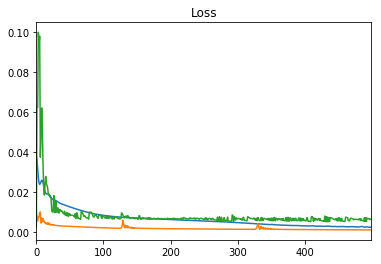

In [14]:
input_buffer = []
output_buffer = []
#anomaly_batches = [0,2,3,18]
anomaly_batches = [3,4,6,25,37]
count = -1 # jump the anomaly batches, not used for retraining
loss_overall = []
err_max_0 = 0
dataBuffer = []

for data in test_set_list:
    count +=1
    
    
    (input_n, output_n) = sess.run([input_, output_], {p_input: data, p_is_training: False})
    input_buffer.append(input_n)
    output_buffer.append(output_n)
    if count in anomaly_batches: 
        continue    
    else:
        dataBuffer.append(data)
        
    if count == 1:
        err_max_0 = max(abs(input_n- output_n).ravel())
        
    # retrain 
    error_max = max(abs(input_n-output_n).ravel())
    if error_max >= err_max_0:
        print("Retrain at batch number %d\n"%count)
        loss = []
        for i in range(500):
            ind = np.random.randint(0,len(dataBuffer))
            d = dataBuffer[ind]
            (loss_val, _) = sess.run([loss_, train_], {p_input: d,p_is_training : True})
            loss.append(loss_val)
            print('Retrain-iter %d:' % (i + 1), loss_val)
        loss_overall.append(loss_val)
        pd.Series(loss).plot(title="Loss")
        dataBuffer.clear()

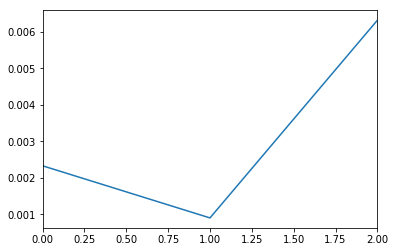

In [15]:
pd.Series(loss_overall).plot()

In [16]:
foo = pd.Series(np.array(input_buffer).ravel())
bar = pd.Series(np.array(output_buffer).ravel())
foobar = pd.concat((foo,bar),axis=1)

foobar.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/retraining_if_error_larger_than_error0.csv",header=['input','output'],index=None)

Normal: Max 0.36, min 0.00, avg 0.05, median 0.04
Abnormal: Max 0.77, min 0.00, avg 0.11, median 0.06


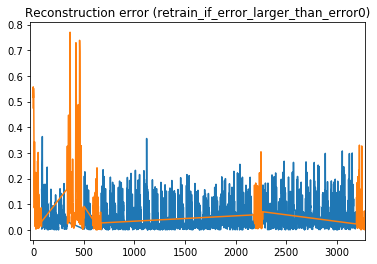

In [17]:
# reconstruction error of normal data(retrain after each batch)

normal =pd.DataFrame( foobar[label[1008:]== 'normal'])
abnormal =pd.DataFrame( foobar[label[1008:]== 'anomaly'])

error1 = abs( normal[0]- normal[1])
error2 = abs( abnormal[0]- abnormal[1])
error1.plot()
error2.plot()
plt.xlim(-30,error1.size+error2.size)
plt.title("Reconstruction error (retrain_if_error_larger_than_error0)")
print("Normal: Max %.2f, min %.2f, avg %.2f, median %.2f"%(max(error1),min(error1), np.mean(error1),np.median(error1)))
print("Abnormal: Max %.2f, min %.2f, avg %.2f, median %.2f"%(max(error2),min(error2), np.mean(error2),np.median(error2)))

In [18]:
# statistical results in batch
normal_batches = [error1[i*(batch_num*step_num):(i+1)*(batch_num*step_num)]for i in range(error1.size//(batch_num*step_num))]
abnormal_batches = [error2[i*(batch_num*step_num):(i+1)*(batch_num*step_num)]for i in range(error2.size//(batch_num*step_num))]

batch_error1  = pd.DataFrame([[max(x),min(x),np.mean(x),np.median(x)] for x in normal_batches])
batch_error2  = pd.DataFrame([[max(y),min(y),np.mean(y),np.median(y)] for y in abnormal_batches])

batch_error1.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/normal_retraining(batch).csv",header=['max','min','avg','median'],index=None)
batch_error2.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/abnormal_retraining(batch).csv",header=['max','min','avg','median'],index=None)


In [19]:
error0 =  abs( foobar[0]- foobar[1])
all_batches = [error0[i*(batch_num*step_num):(i+1)*(batch_num*step_num)]for i in range(error0.size//(batch_num*step_num))]
batch_error0  = pd.DataFrame([[max(x),min(x),np.mean(x),np.median(x)] for x in all_batches])
batch_error0.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/all_retraining(batch).csv",header=['max','min','avg','median'],index=None)


In [20]:
data = pd.read_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/retraining_if_error_larger_than_error0.csv")

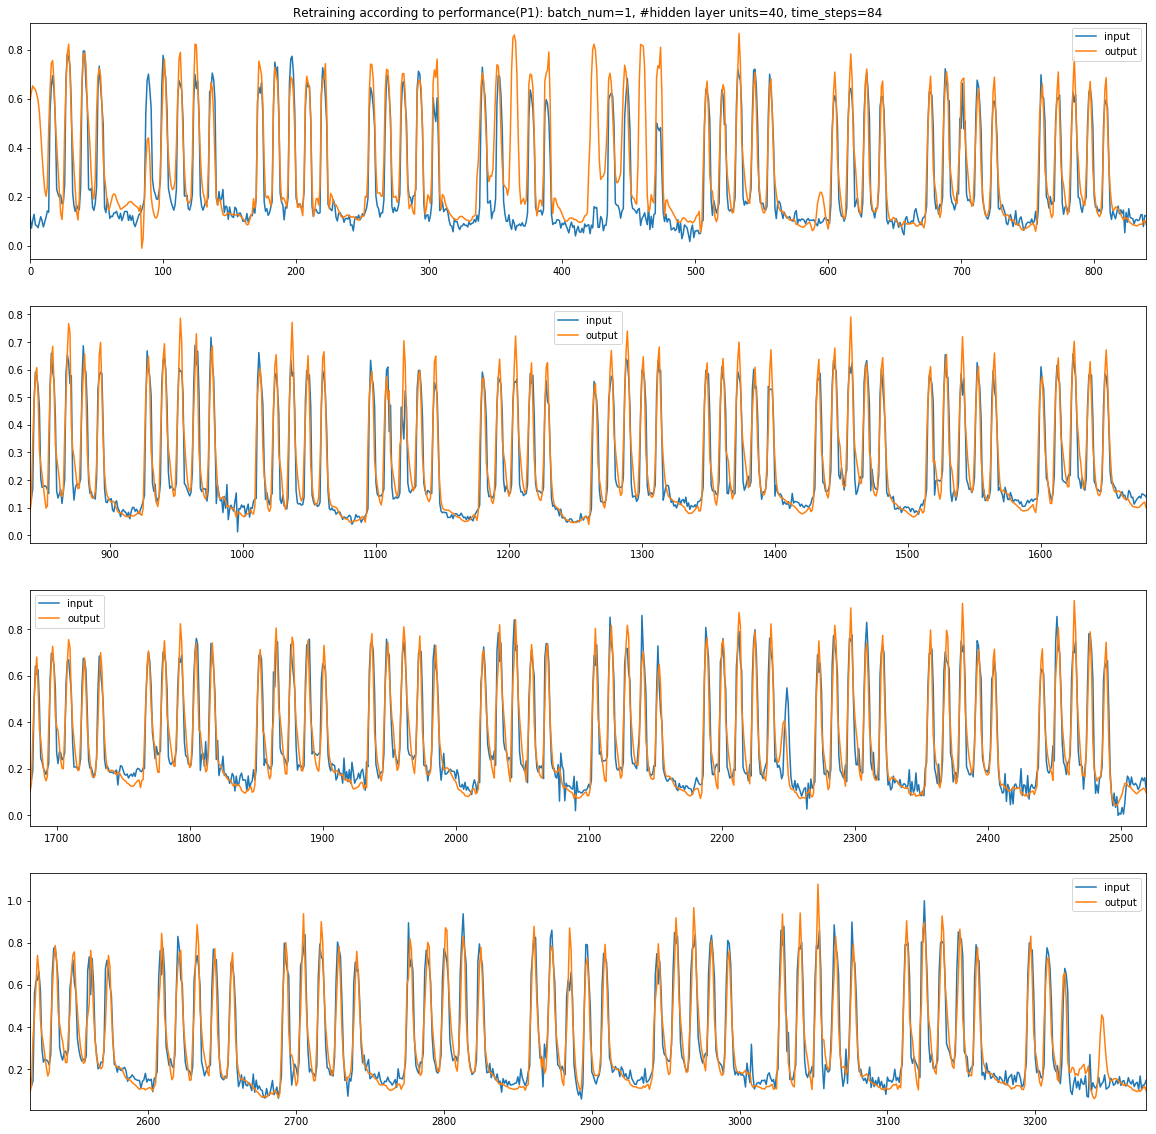

In [21]:
fig, axes = plt.subplots(nrows=4, ncols=1,figsize=(20,20))
axes[0].set_title("Retraining according to performance(P1): batch_num=1, #hidden layer units=40, time_steps=84")
data[:840].plot(ax=axes[0])
data[840*1:840*2].plot(ax=axes[1])
data[840*2:840*3].plot(ax=axes[2])
data[840*3:].plot(ax=axes[3])


(0, 1)

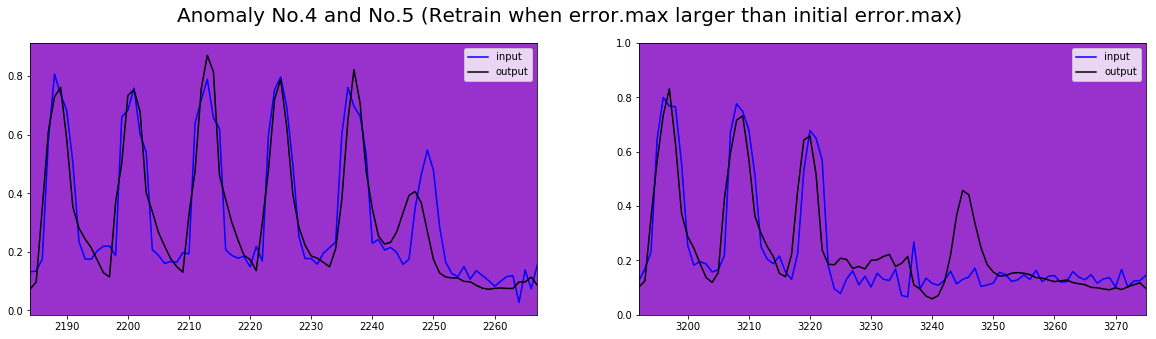

In [22]:
fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2,figsize=(20,5))
plt.suptitle("Anomaly No.4 and No.5 (Retrain when error.max larger than initial error.max)", fontsize=20)
data[84*26:84*27].plot(ax=ax0,color=['blue','black'])
data[-84:].plot(ax=ax1,color=['blue','black'])
ax0.set_facecolor('darkorchid')
ax1.set_facecolor('darkorchid')
plt.ylim(0,1)

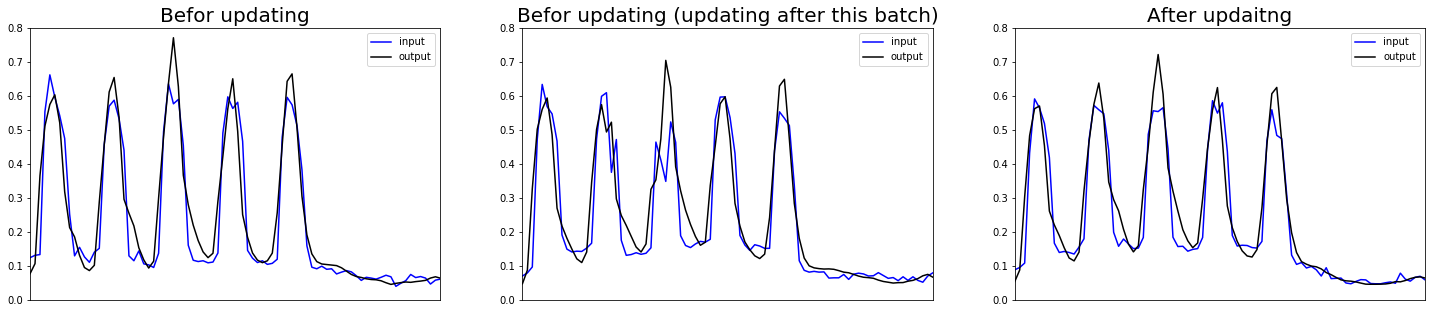

In [23]:
fig, (ax0,ax1,ax2) = plt.subplots(nrows=1, ncols=3,figsize=(25,5))

#plt.suptitle("Befor & after retraining")
data[84*12:84*13].plot(ax=ax0,color=['blue','black'])
data[84*13:84*14].plot(ax=ax1,color=['blue','black'])
data[84*14:84*15].plot(ax=ax2,color=['blue','black'])
#ax0.set_facecolor('darkorchid')
#ax1.set_facecolor('darkorchid')
#ax2.set_facecolor('darkorchid')
ax0.set_title("Befor updating", fontsize=20)
ax1.set_title("Befor updating (updating after this batch)", fontsize=20)
ax2.set_title("After updaitng", fontsize=20)
ax0.set_ylim(0,0.8)
ax1.set_ylim(0,0.8)
ax2.set_ylim(0,0.8)
ax0.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)